In [35]:
import arviz as az
import pandas as pd
import json
import os

import numpy as np
import diffrax
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import sys
from scipy.stats import mode

jax.config.update("jax_enable_x64", True)

%matplotlib inline
plt.style.use('custom')

# custom plotting helper funcs
sys.path.insert(0, '../')
from plotting_helper_funcs import *
from utils import *

rng = np.random.default_rng(seed=1234)

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


Now load in all of the posterior idata and the posterior predictive samples...

In [36]:
savedir = '../../../results/MAPK/param_est/HF96_traj_synthetic_data/'

model_info = json.load(open('../param_est/model_info.json'))
model_names = list(model_info.keys())
display_names = [model_info[model]['display_name'] for model in model_names]

idata = {}
posterior_pred_samples = {}
posterior_samples = {}
ss = {}
log_marginal_likes = []

for model in model_names:
    idata[model], ss[model] = load_smc_samples_to_idata(savedir+model+'/'+model+'_smc_samples.json')
    posterior_pred_samples[model] = np.load(savedir+model+'/'+model+'_posterior_predictive_samples.npy')
    posterior_samples[model] = np.load(savedir+model+'/traj_predict.npy')
    


# Log marginal likelihoods
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['kholodenko_2000']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['levchenko_2000']['log_marginal_likelihood'][0]]))
log_marginal_likes.append( np.mean([chain[-1] for chain in ss['hatakeyama_2003']['log_marginal_likelihood']]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['hornberg_2005']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['birtwistle_2007']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['orton_2009']['log_marginal_likelihood'][0]]))
log_marginal_likes.append( np.mean([chain[-1] for chain in ss['vonKriegsheim_2009']['log_marginal_likelihood'][0]])) 
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['shin_2014']['log_marginal_likelihood']]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['ryu_2015']['log_marginal_likelihood'][0]]))
log_marginal_likes.append(np.mean([chain[-1] for chain in ss['kochanczyk_2017']['log_marginal_likelihood']]))

log_marginal_likes = np.array(log_marginal_likes)

# posterior_pred_samples_mod = posterior_pred_samples.copy()
# # Birtwistle 2007 only has 400 posterior predictive samples, so we duplicate and randomly permute them 
# # to get 4000
# B_2007_posts = [posterior_pred_samples_mod['birtwistle_2007'] for _ in range(10)]
# B_2007_post = np.vstack(B_2007_posts)
# posterior_pred_samples_mod['birtwistle_2007'] = B_2007_post[rng.permutation(np.arange(4000))]

# # vonKreigsheim 2009 only has 400 posterior predictive samples, so we duplicate and randomly permute them to get 4000
# vK_2009_posts = [posterior_pred_samples_mod['vonKriegsheim_2009'] for _ in range(10)]
# vK_2009_post = np.vstack(vK_2009_posts)
# posterior_pred_samples_mod['vonKriegsheim_2009'] = vK_2009_post[rng.permutation(np.arange(4000))]

# Hornberg 2005 only has 560 posterior predictive samples, so we duplicate and randomly permute them to get 2000
H_2005_posts = [posterior_pred_samples['hornberg_2005'] for _ in range(10)]
H_2005_post = np.vstack(H_2005_posts)
posterior_pred_samples['hornberg_2005'] = H_2005_post[rng.permutation(np.arange(2000))]

# Orton 2009 only has 800 posterior predictive samples, so we duplicate and randomly permute them to get 2000
O_2009_posts = [posterior_pred_samples['orton_2009'] for _ in range(10)]
O_2009_post = np.vstack(O_2009_posts)
posterior_pred_samples['orton_2009'] = O_2009_post[rng.permutation(np.arange(2000))]

#von Kriegsheim 2009 only has 600 posterior predictive samples, so we duplicate and randomly permute them to get 2000
vK_2009_posts = [posterior_pred_samples['vonKriegsheim_2009'] for _ in range(10)]
vK_2009_post = np.vstack(vK_2009_posts)
posterior_pred_samples['vonKriegsheim_2009'] = vK_2009_post[rng.permutation(np.arange(2000))]

# shin has 4000 so downsample to 2000
idxs = rng.choice(np.arange(4000), size=2000, replace=False)
posterior_pred_samples['shin_2014'] = posterior_pred_samples['shin_2014'][idxs]

# posterior_pred_samples = posterior_pred_samples_mod

# dose-resposne data
inputs, data = load_data('../../../results/MAPK/HF_96_synthetic_data.csv')

# load trajectory data
inputs_traj, data_traj, data_std_traj, times_traj = load_data_json('../../../results/MAPK/HF_96_traj_data.json', data_std=True, time=True)
data_time_to_mins = 60

# set up a color palette
# this is the ColorBrewer purple-green with 11 colors + three greys https://colorbrewer2.org/#type=diverging&scheme=PRGn&n=11
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b','#363737','#929591','#d8dcd6']
# this one gets to 10 colors by removing the darkest purple
colors = ['#40004b','#762a83','#9970ab','#c2a5cf','#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#363737','#929591','#d8dcd6']
orange = '#de8f05'

Now run arviz model comparison get eldpd_loo for each model and save to a dict

In [37]:
compare_data_waic_pbma = az.compare(idata, ic='waic', method='BB-pseudo-BMA', seed=rng)
compare_data_loo_pbma = az.compare(idata, ic='loo', method='BB-pseudo-BMA', seed=rng)
compare_data_waic_stack = az.compare(idata, ic='waic', method='stacking', seed=rng)
compare_data_loo_stack = az.compare(idata, ic='loo', method='stacking', seed=rng)

/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/natetest/miniforge3/envs/pymc/lib/python3.11/sit

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_35593/2637268312.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_35593/2637268312.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


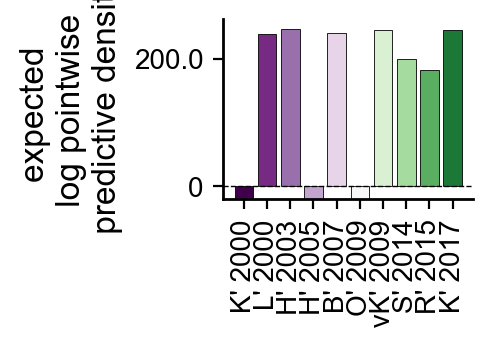

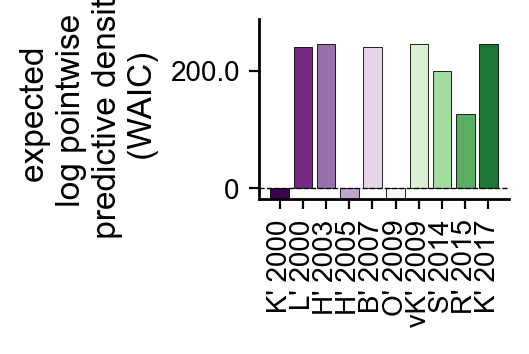

In [50]:
# make a plot of elpd_loo, and elpd_waic
dat = [compare_data_loo_stack.loc[model]['elpd_loo'] for model in model_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(model_names, dat, edgecolor='k')
ax.set_ylabel('expected \n log pointwise \n predictive density', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ylim = ax.get_ylim()
ax.set_ylim(-0.04*ylim[1], 0.5*ylim[1])
ax.set_yticks([0, 200.0])
ax.set_yticklabels([0, 200.0], fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/HF96_traj_elpd_loo.pdf', transparent=True)

# waic
dat = [compare_data_waic_stack.loc[model]['elpd_waic'] for model in model_names]
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(model_names, dat, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])

ax.set_ylabel('expected \n log pointwise \n predictive density \n (WAIC)', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ylim = ax.get_ylim()
ax.set_ylim(-0.01*ylim[1], 0.15*ylim[1])
ax.set_yticks([0, 200.0])
ax.set_yticklabels([0, 200.0], fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/HF96_traj_elpd_waic.pdf', transparent=True)

## Bayesian model averaging - plot bar plot of model probabilities

In [39]:
# function to compute log sum exponential in a numerically stable way
def logsumexp(x):
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x - c)))

def weight_with_logsumexp(log_values):
    return np.exp(log_values - logsumexp(log_values))

[2.67731650e-164 5.74528451e-006 3.31162497e-004 0.00000000e+000
 5.14961154e-007 0.00000000e+000 9.38472481e-001 9.69723313e-020
 4.05624329e-020 6.11900963e-002]


/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_35593/2515392052.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)


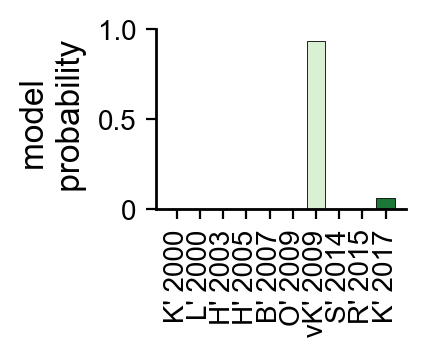

In [40]:
n_models = len(log_marginal_likes)
prior_prob = 1/n_models

model_probs = weight_with_logsumexp(np.log(prior_prob)+log_marginal_likes)
print(model_probs)
fig, ax = get_sized_fig_ax(1.25, 0.9)
bar = ax.bar(model_names, model_probs, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])

ax.set_ylabel('model \n probability', fontsize=12)
xlim = ax.get_xlim()
ax.plot(xlim, [0,0], '--k', linewidth=0.5)
ax.set_xlim(xlim)
ax.set_ylim([0, 1.0])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontsize=10.0)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
# ax.set_ylim([0, 1.0])
fig.savefig('../../../results/MAPK/mmi/HF96_traj_model_prob.pdf', transparent=True)

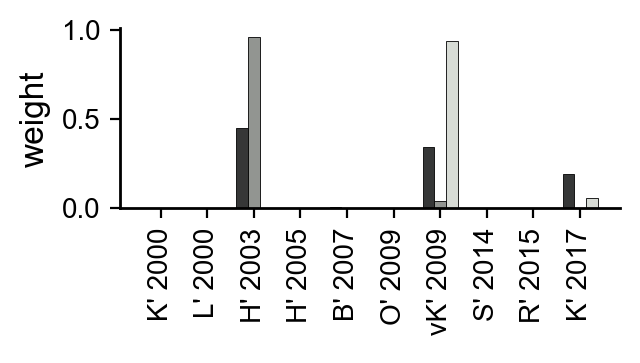

In [45]:
x = np.arange(n_models)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

stack = [compare_data_loo_stack.loc[model]['weight'] for model in model_names]
pBMA = [compare_data_loo_pbma.loc[model]['weight'] for model in model_names]

# 
fig, ax = get_sized_fig_ax(2.5, 0.9)
for dat, name, col in zip([pBMA, stack, model_probs], ['pseudo-BMA','stacking','BMA',], [colors[-3], colors[-2], colors[-1]]):
    offset = width * multiplier
    bar = ax.bar(x + offset, dat, width, label=name, color=col, edgecolor='k')
    # ax.bar_label(bar, padding=3)
    multiplier += 1

ax.set_ylabel('model weight', fontsize=12)
ax.set_xticks(x + width, display_names)
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_yticklabels(['0.0', '0.5', '1.0'], fontsize=10.0)
leg = ax.legend(loc='center', fontsize=8.0, bbox_to_anchor=(0.5, 1.3), ncol=1)
export_legend(leg, filename='../../../results/MAPK/mmi/HF96_traj_model_weights_legend.pdf')
leg.remove()

ax.set_ylabel(r'weight', fontsize=12)
ax.set_xticklabels(display_names, rotation=90, fontsize=10.0)
# ax.set_ylim([0, 1.0])
fig.savefig('../../../results/MAPK/mmi/HF96_traj_model_weights.pdf', transparent=True)

Generate predictive samples from the averaged predictive density

In [25]:
# first wiith posterior predictive samples
loo_pbma_combined = np.zeros_like(posterior_pred_samples['kholodenko_2000'])
loo_stack_combined = np.zeros_like(posterior_pred_samples['kholodenko_2000'])
loo_bma_combined = np.zeros_like(posterior_pred_samples['kholodenko_2000'])
for i, name in enumerate(model_names):
    loo_pbma_combined += compare_data_loo_pbma.loc[name]['weight']*posterior_pred_samples[name]
    loo_stack_combined += compare_data_loo_stack.loc[name]['weight']*posterior_pred_samples[name]
    loo_bma_combined += model_probs[i]*posterior_pred_samples[name]

# then with posterior samples
loo_pbma_combined_post = np.zeros_like(posterior_samples['kholodenko_2000'])
loo_stack_combined_post = np.zeros_like(posterior_samples['kholodenko_2000'])
loo_bma_combined_post = np.zeros_like(posterior_samples['kholodenko_2000'])
for i, name in enumerate(model_names):
    loo_pbma_combined_post += compare_data_loo_pbma.loc[name]['weight']*posterior_samples[name]
    loo_stack_combined_post += compare_data_loo_stack.loc[name]['weight']*posterior_samples[name]
    loo_bma_combined_post += model_probs[i]*posterior_samples[name]

In [26]:
def plot_stimulus_response_curve(samples, data, inputs, box_color='k', data_color='r', input_name='EGF stimulus', 
                                 output_name='% maximal ERK activity',
                                 data_std=0.1, width=6.0, height=3.0, scatter_marker_size=50, data_marker_size=7):
    dat = {}
    for i,input in enumerate(inputs):
        dat[input] = samples[:,i]

    data_df = pd.DataFrame(dat)

    fig, ax = get_sized_fig_ax(width, height)
    sns.boxplot(data=data_df, color=box_color, ax=ax, whis=(2.5, 97.5), fill=True, 
                native_scale=True, log_scale=(10, 0), fliersize=0, width=0.65)
    ax.set_xlabel(input_name)
    ax.set_ylabel(output_name)

    errors = data_std*np.squeeze(np.ones_like(data))
    ax.scatter(inputs, data, color=data_color, marker='x', s=scatter_marker_size, zorder=10, label='synthetic data')
    ax.errorbar(inputs, np.squeeze(data), yerr=errors, color=data_color, fmt='x', markersize=data_marker_size, zorder=10)

    return fig, ax

In [27]:
# with posterior pred samples
trajs_mmi = {
    'pseudo-BMA': loo_pbma_combined,
    'stacking': loo_stack_combined,
    'BMA': loo_bma_combined
}

fig_savedir = '../../../results/MAPK/mmi/HF96_traj_'
cols = [colors[-3], colors[-2], colors[-1]]
for idx, name in enumerate(trajs_mmi.keys()):
    plot_posterior_trajectories(trajs_mmi[name], data_traj, data_std_traj, times_traj, cols[idx], 
                                            inputs_traj, fig_savedir,
                                            name, data_time_to_mins=60,
                                            width=1.1, height=0.5, 
                                            data_downsample=10,
                                            ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                            y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]],
                                            fname='_mmi_traj_', labels=False)

plt.close('all')

# with posterior samples
trajs_mmi_post = {
    'pseudo-BMA': loo_pbma_combined_post,
    'stacking': loo_stack_combined_post,
    'BMA': loo_bma_combined_post
}

fig_savedir = '../../../results/MAPK/mmi/HF96_traj_'
cols = [colors[-3], colors[-2], colors[-1]]
for idx, name in enumerate(trajs_mmi.keys()):
    plot_posterior_trajectories(trajs_mmi[name], data_traj, data_std_traj, times_traj, cols[idx], 
                                            inputs_traj, fig_savedir,
                                            name, data_time_to_mins=60,
                                            width=1.1, height=0.5, 
                                            data_downsample=10,
                                            ylim=[[0.0, 1.2], [0.0, 1.2], [0.0, 1.2]],
                                            y_ticks=[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]],
                                            fname='_mmi_post_traj_', labels=False)
plt.close('all')

Now compute RMSE for each model. Will do this for each model averaged predictive sample then make a bar plot with error bars

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_35593/4224785318.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_35593/4224785318.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


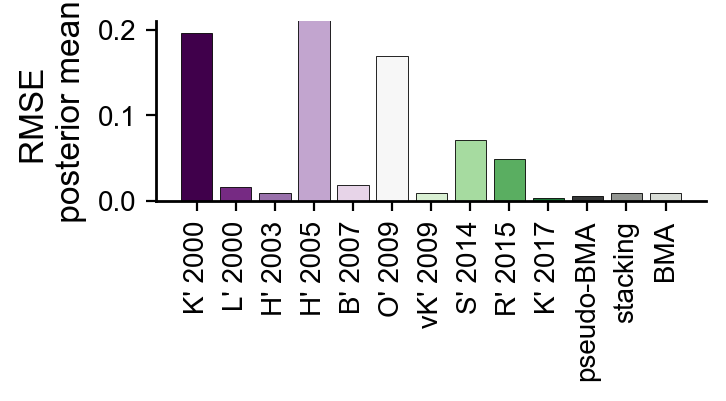

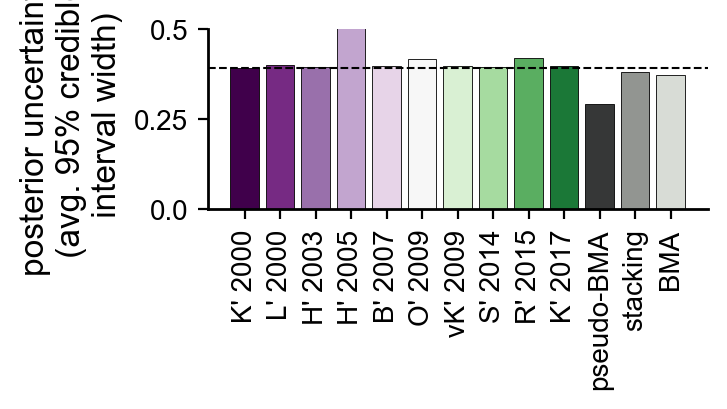

In [51]:
RMSE_samples_pred = {}
credible_95_pred = {}
for name in model_names:
    RMSE_samples_pred[name] = list(np.sqrt(np.nanmean((np.nanmean(posterior_pred_samples[name], axis=0) - data_traj)**2, axis=1)))
    credible_95_pred[name] = list(np.nanmean(np.squeeze(np.diff(np.nanquantile(posterior_pred_samples[name], [0.025, 0.975], axis=0),axis=0)), axis=1))

# add MMI stats
for name in trajs_mmi.keys():
    RMSE_samples_pred[name] = list(np.sqrt(np.nanmean((np.nanmean(trajs_mmi[name], axis=0) - data_traj)**2, axis=1)))
    credible_95_pred[name] = list(np.nanmean(np.squeeze(np.diff(np.nanquantile(trajs_mmi[name], [0.025, 0.975], axis=0),axis=0)), axis=1))

stats_pred = {
    'RMSE':RMSE_samples_pred,
    'credible_95':credible_95_pred,
}

RMSE_avg = np.mean(np.array(list(RMSE_samples_pred.values())), axis=1)
credible_95_avg = np.mean(np.array(list(credible_95_pred.values())), axis=1)

# make plots
fig, ax = get_sized_fig_ax(2.75, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], RMSE_avg, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
    
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
ax.set_ylim([0, 0.21])
ax.set_yticks([0.0, 0.1, 0.2])
ax.set_yticklabels([0.0, 0.1, 0.2], fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/HF96_traj_RMSE.pdf', transparent=True)

min_index_95 = np.argmin(credible_95_avg[0:10])
fig, ax = get_sized_fig_ax(2.5, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], credible_95_avg, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [credible_95_avg[min_index_95]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
ax.set_ylim([0, 0.5])
ax.set_yticks([0.0, 0.25, 0.5])
ax.set_yticklabels([0.0, 0.25, 0.5], fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/HF96_traj_post_uncert_95.pdf', transparent=True)

/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_35593/3059447225.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
/var/folders/8n/spw3_jx50513cdpgqqxx58cr0000gp/T/ipykernel_35593/3059447225.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)


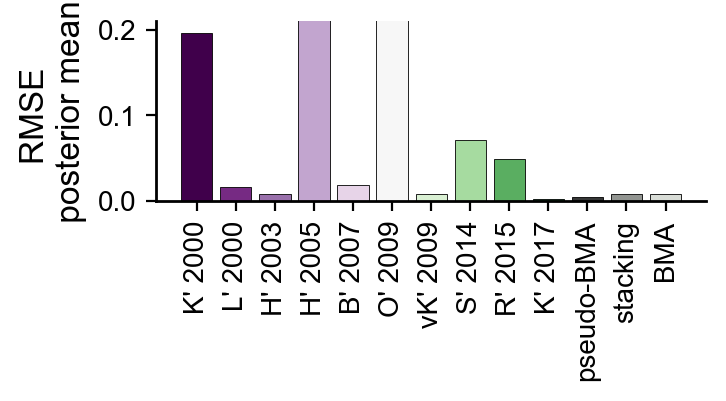

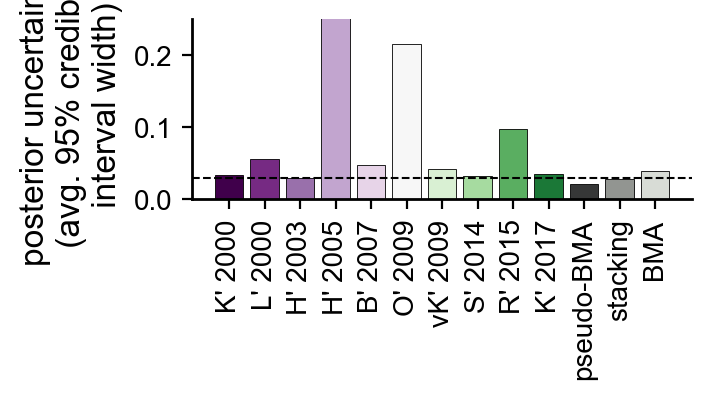

In [52]:
RMSE_samples = {}
credible_95 = {}
for name in model_names:
    RMSE_samples[name] = list(np.sqrt(np.nanmean((np.nanmean(posterior_samples[name], axis=0) - data_traj)**2, axis=1)))
    credible_95[name] = list(np.nanmean(np.squeeze(np.diff(np.nanquantile(posterior_samples[name], [0.025, 0.975], axis=0),axis=0)), axis=1))

# add MMI stats
for name in trajs_mmi.keys():
    RMSE_samples[name] = list(np.sqrt(np.nanmean((np.nanmean(trajs_mmi_post[name], axis=0) - data_traj)**2, axis=1)))
    credible_95[name] = list(np.nanmean(np.squeeze(np.diff(np.nanquantile(trajs_mmi_post[name], [0.025, 0.975], axis=0),axis=0)), axis=1))

stats = {
    'RMSE':RMSE_samples,
    'credible_95':credible_95,
}

RMSE_avg = np.mean(np.array(list(RMSE_samples.values())), axis=1)
credible_95_avg = np.mean(np.array(list(credible_95.values())), axis=1)

# make plots
fig, ax = get_sized_fig_ax(2.75, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], RMSE_avg, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
    
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('RMSE \n posterior mean ', fontsize=12.0)
ax.set_ylim([0, 0.21])
ax.set_yticks([0.0, 0.1, 0.2])
ax.set_yticklabels([0.0, 0.1, 0.2], fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/HF96_traj_RMSE_post.pdf', transparent=True)

min_index_95 = np.argmin(credible_95_avg[0:10])
fig, ax = get_sized_fig_ax(2.5, 0.9)
bar = ax.bar(display_names + ['pseudo-BMA', 'stacking', 'BMA'], credible_95_avg, edgecolor='k')
for i, br in enumerate(bar):
    br.set_facecolor(colors[i])
xlim = ax.get_xlim()
ax.plot(xlim, [credible_95_avg[min_index_95]]*2, 'k--', linewidth=0.75)
ax.set_xlim(xlim)
ax.set_xticklabels(display_names + ['pseudo-BMA', 'stacking', 'BMA'], rotation=90, fontsize=10.0)
ax.set_ylabel('posterior uncertainty \n (avg. 95% credible \n interval width)', fontsize=12.0)
ax.set_ylim([0, 0.25])
ax.set_yticks([0.0, 0.1, 0.2])
ax.set_yticklabels([0.0, 0.1, 0.2], fontsize=10.0)
fig.savefig('../../../results/MAPK/mmi/HF96_traj_post_uncert_95_post.pdf', transparent=True)

In [30]:
stats = {
    'RMSE':{
        'post_pred':RMSE_samples_pred,
        'post':RMSE_samples,
    },
    'credible_95':{
        'post_pred':credible_95_pred,
        'post':credible_95,
    },
}

with open('../../../results/MAPK/mmi/HF96_traj_all_models_MMI_stats.json', 'w') as file:
    file.write(json.dumps(stats))

### Make MMI predictions of dose-response curves

In [31]:
# load posterior predictions of dynamics
savedir = '../../../results/MAPK/param_est/HF96_traj_synthetic_data/'

dose_responses = {}

for model in model_names:
    dose_responses[model] = np.load(savedir+model+'/dose_response_predict.npy')

Now perform weighted averaging of the posterior predictive samples from each model

In [32]:
loo_pbma_combined_dose_response = np.zeros_like(dose_responses['kholodenko_2000'])
loo_stack_combined_dose_response = np.zeros_like(dose_responses['kholodenko_2000'])
loo_bma_combined_dose_response = np.zeros_like(dose_responses['kholodenko_2000'])
for i, name in enumerate(dose_responses.keys()):
    loo_pbma_combined_dose_response += compare_data_loo_pbma.loc[name]['weight']*dose_responses[name]
    loo_stack_combined_dose_response += compare_data_loo_stack.loc[name]['weight']*dose_responses[name]
    loo_bma_combined_dose_response += model_probs[i]*dose_responses[name]

dose_responses_mmi = {'loo_pbma_combined_dose_response':loo_pbma_combined_dose_response,
         'loo_stack_combined_dose_response':loo_stack_combined_dose_response,
         'loo_bma_combined_dose_response':loo_bma_combined_dose_response}

# times = np.linspace(0.0, 240.0, loo_bma_combined_traj.shape[2])

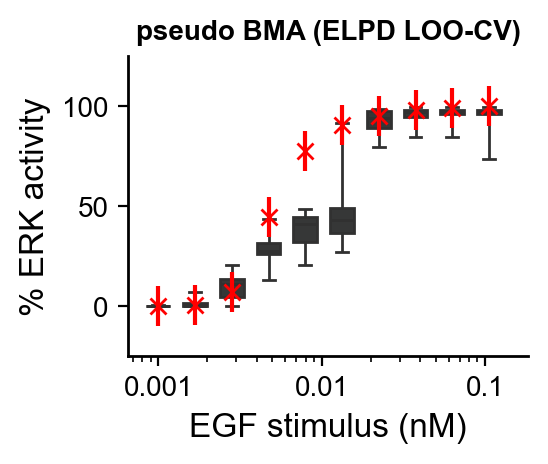

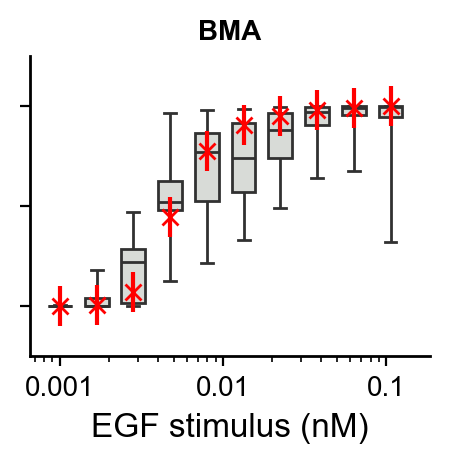

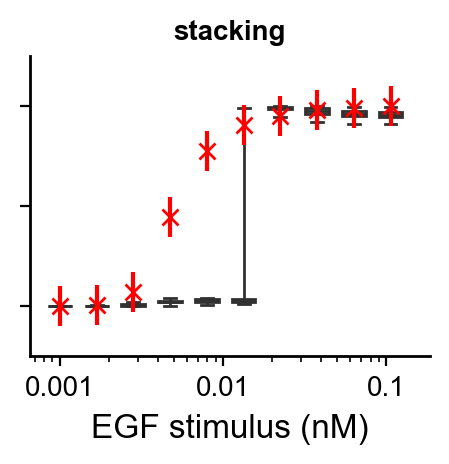

In [33]:
fig, ax = plot_stimulus_response_curve(loo_pbma_combined_dose_response, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% ERK activity', box_color=colors[-3], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('pseudo BMA (ELPD LOO-CV)', fontsize=10)
leg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_pbma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0', '50', '100'], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
ax.set_ylabel(ax.get_ylabel(), fontsize=12.0)

fig.savefig('../../../results/MAPK/mmi/HF96_traj_pbma_avg.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(loo_bma_combined_dose_response, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-1], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)
ax.set_title('BMA', fontsize=10)
leg = ax.legend()

leg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
export_legend(leg, '../../../results/MAPK/mmi/HF96_bma_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')

fig.savefig('../../../results/MAPK/mmi/HF96_traj_bma_avg.pdf', transparent=True)

fig, ax = plot_stimulus_response_curve(loo_stack_combined_dose_response, data, inputs, input_name='EGF stimulus (nM)', 
                                 output_name='% maximal ERK activity', box_color=colors[-2], data_color='red',
                                 data_std=0.1, width=2., height=1.5, data_marker_size=6.0, scatter_marker_size=0)

ax.set_title('stacking', fontsize=10)
leg = ax.legend()

leg = ax.legend(ncols=6, fontsize=10, bbox_to_anchor=(10, 10))
# export_legend(leg, '../../../results/MAPK/mmi/HF96_stack_avg_legend.pdf')
leg.remove()

ax.set_ylim([-0.25, 1.25])
ax.set_yticks([0, 0.5, 1.0])
# ax.set_yticklabels(['0', '50', '100'], fontsize=8)
ax.set_yticklabels([], fontsize=10.0)
ax.set_xticks([0.001, 0.01, 0.1])
ax.set_xticklabels([0.001, 0.01, 0.1], fontsize=10.0)
ax.set_xlabel(ax.get_xlabel(), fontsize=12.0)
# ax.set_ylabel(ax.get_ylabel(), fontsize=10.0)
ax.set_ylabel('')

fig.savefig('../../../results/MAPK/mmi/HF96_traj_stack_avg.pdf', transparent=True)

#### Compute posterior RMSE and Uncertainty

In [34]:
RMSE = {}
credible_95 = {}
for name in model_names:
    RMSE[name] = list(np.sqrt(np.nanmean((np.nanmean(dose_responses[name], axis=0) - data.T)**2, axis=1)))
    credible_95[name] = np.nanmean(np.diff(np.nanquantile(dose_responses[name], [0.025, 0.975], axis=0),axis=0))

# add MMI stats
for name in dose_responses_mmi.keys():
    RMSE[name] = list(np.sqrt(np.nanmean((np.nanmean(dose_responses_mmi[name], axis=0) - data.T)**2, axis=1)))
    credible_95[name] = np.nanmean(np.diff(np.nanquantile(dose_responses_mmi[name], [0.025, 0.975], axis=0),axis=0))

stats = {
    'RMSE':RMSE,
    'credible_95':credible_95,
}

with open('../../../results/MAPK/mmi/HF96_traj_synth_pred_DR_stats.json', 'w') as file:
    file.write(json.dumps(stats))